In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose



#Import the dataset for Malin Head
time_series = pd.read_csv('data/hourly_data/hly1575.csv', skiprows=23,skipinitialspace=True, index_col=False, low_memory=False)

#Rename the columns
time_series.columns = ['Date/Time (utc)', 'Indicator', 'Precipitation Amount (mm)', 'Indicator', 'Temperature (°C)', 'Indicator', 'Wet Bulb Temperature (°C)', 'Dew Point Temp (°C)', 'Vapour Pressure (hPa)','Relative Humidity (%)', 'Mean Sea Level Pressure (hPa)','Indicator', 'Mean Wind Speed (knot)', 'Indicator', 'Predominant Wind Direction (deg)', 'Present Weather', 'Past Weather', 'Sunshine duration (hours)', 'Visibility', 'Cloud Height (ft * 100s)', 'Cloud amount']

#Format the date column as a datetime object
time_series['Date/Time (utc)'] = pd.to_datetime(time_series['Date/Time (utc)'], format='%d-%b-%Y %H:%M')

#Add a year and month column
time_series['Year'] = time_series['Date/Time (utc)'].dt.year
time_series['Month'] = time_series['Date/Time (utc)'].dt.month

#Convert the windspeed data to m/s
time_series['Mean Wind Speed (m/s)'] = time_series['Mean Wind Speed (knot)'] * 0.514444

#Select just the columns we are interested in
time_series = time_series[['Date/Time (utc)','Mean Wind Speed (m/s)', 'Month', 'Year']]

time_series['Mean Wind Speed (m/s)'] = pd.to_numeric(time_series['Mean Wind Speed (m/s)'], errors="coerce")
median_value = time_series['Mean Wind Speed (m/s)'].median()
time_series['Mean Wind Speed (m/s)'] = time_series['Mean Wind Speed (m/s)'].fillna(median_value)


#Have a quick look at our data to see if it has been loaded correctly
time_series.head()

,Date/Time (utc),Mean Wind Speed (m/s),Month,Year
0,1955-05-01 01:00:00,5.658884,5,1955
1,1955-05-01 02:00:00,5.658884,5,1955
2,1955-05-01 03:00:00,4.115552,5,1955
3,1955-05-01 04:00:00,9.259992,5,1955
4,1955-05-01 05:00:00,4.629996,5,1955


In [2]:


# Define a function to map months to seasons
def get_season(month):
    if month in [11, 12, 1]:
        return 'Winter'
    elif month in [2, 3, 4]:
        return 'Spring'
    elif month in [5, 6, 7]:
        return 'Summer'
    else:
        return 'Autumn'


# Apply the function to assign a season to each row based on the month
time_series['Season'] = time_series['Date/Time (utc)'].dt.month.apply(get_season)

# Group the data by year and season and calculate the mean wind speed for each group
data_seasonal = time_series.groupby(['Year', 'Season']).agg({'Mean Wind Speed (m/s)': 'mean'}).reset_index()

# Map seasons to ordinal values for numerical representation
season_mapping = {'Winter': 1, 'Spring': 2, 'Summer': 3, 'Autumn': 4}
data_seasonal['Season Ordinal'] = data_seasonal['Season'].map(season_mapping)

# Create a combined "year-season ordinal" feature for time-series modeling
# This combines year and season into a single numerical index
data_seasonal['Year Season Ordinal'] = data_seasonal['Year'] + data_seasonal['Season Ordinal'] / 10.0

# Define the features (X) and target variable (y) for modeling
X = data_seasonal[['Year Season Ordinal']] 
y = data_seasonal['Mean Wind Speed (m/s)']

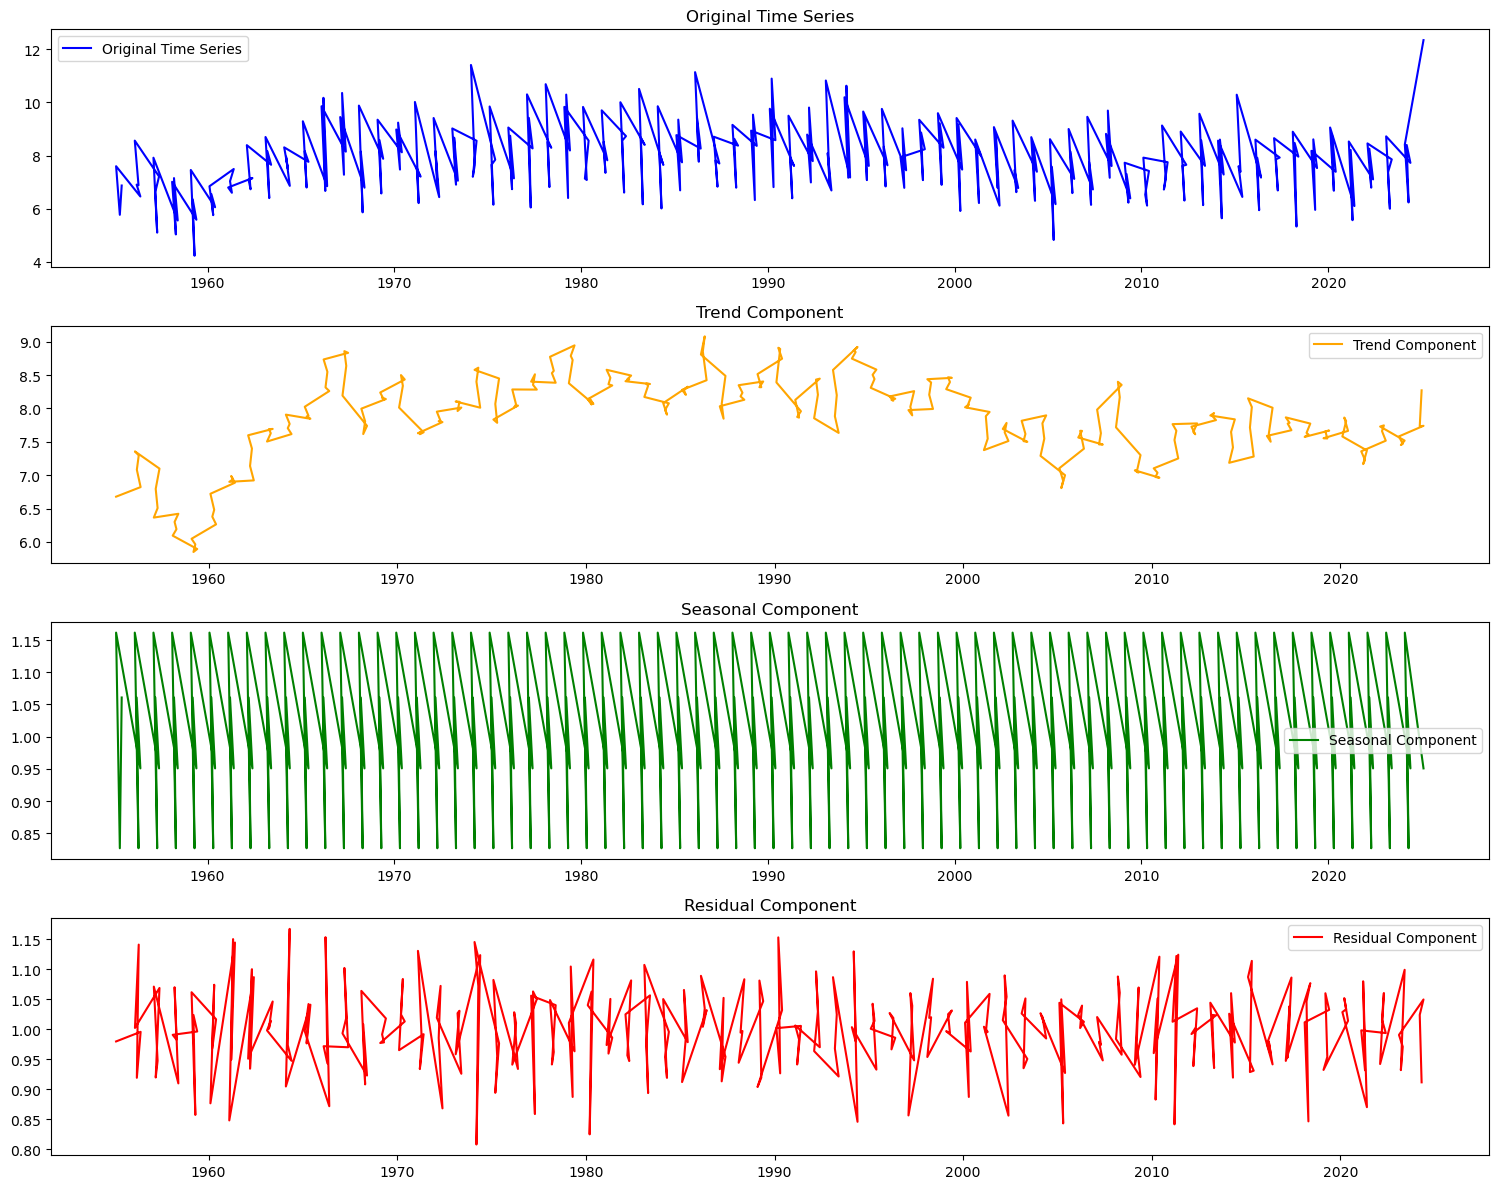

In [3]:
# Set the time series data with 'year_season_ordinal' as the index and 'wdsp_mps' as the values
time_series = data_seasonal.set_index('Year Season Ordinal')['Mean Wind Speed (m/s)']

# Perform seasonal decomposition on the time series
# The decomposition is multiplicative because seasonal variations are assumed to scale with the level of the data
# 'period=4' indicates that the data has a quarterly seasonal pattern (4 seasons per year)
decomposition = seasonal_decompose(time_series, model='multiplicative', period=4)


# Extract the components of the decomposition: trend, seasonal, and residual
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plotting. Set the figure size
plt.figure(figsize=(15, 12))

# Plot the original time series
plt.subplot(4, 1, 1)
plt.plot(time_series, label='Original Time Series', color='blue')
plt.title('Original Time Series')
plt.legend()


# Plot the trend component
plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend Component', color='orange')
plt.title('Trend Component')
plt.legend()

# Plot the seasonal component
plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal Component', color='green')
plt.title('Seasonal Component')
plt.legend()

# Plot the residual component
plt.subplot(4, 1, 4)
plt.plot(residual, label='Residual Component', color='red')
plt.title('Residual Component')
plt.legend()

plt.tight_layout()

c:\Users\micha\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Mean Squared Error: 1.8498
Mean Absolute Error: 1.0394
R^2 Score: -0.1634
MAPE: 14.83%


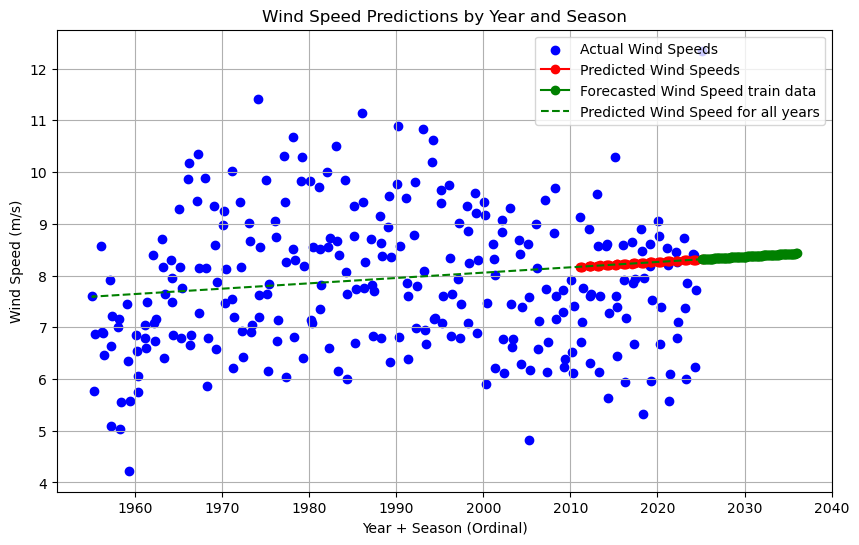

In [27]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize and train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)


#Predict the wind speed for the next 10 years
forecast = np.arange(data_seasonal['Year Season Ordinal'].max(), data_seasonal['Year Season Ordinal'].max()+ 11, 0.1).reshape(-1, 1)
#The reshape function is used to convert the array to a 2D array. The -1 is used to infer the number of rows based on the number of columns
#The 1 is the number of columns in the reshaped array. In this case, we are reshaping the array to have 1 column.
predictions = model.predict(forecast)

#Predict the wind speed for all the years
predictions_all = model.predict(X)

#Combine actual and forecasted data
forecasted_wind = pd.DataFrame({'Year': forecast.flatten(), 'Average Wind Speed (m/s)': predictions})
all_wind = pd.concat([data_seasonal, forecasted_wind], ignore_index=True)



# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2_score = model.score(X_test, y_test)
y_test_corrected = y_test.replace(0, 0.01)
mape = mean_absolute_percentage_error(y_test_corrected, y_pred)

# Print the evaluation metrics
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R^2 Score: {r2_score:.4f}")
print(f"MAPE: {mape * 100:.2f}%")

# Visualize the predictions
plt.figure(figsize=(10, 6))
plt.scatter(X, y, label='Actual Wind Speeds', color='blue', marker='o')
plt.plot(X_test, y_pred, 'o-', label='Predicted Wind Speeds', color='red')
plt.plot(forecast.flatten(), predictions, 'o-', label='Forecasted Wind Speed train data', color='green')
plt.plot(X, predictions_all, label='Predicted Wind Speed for all years', color='green', linestyle='--')
plt.xlabel('Year + Season (Ordinal)')
plt.ylabel('Wind Speed (m/s)')
plt.title('Wind Speed Predictions by Year and Season')
plt.legend()
plt.grid(True)

In [28]:
# Make a copy of the original dataset to ensure the original data remains unchanged
data_seasonal = data_seasonal.copy()

# Create a new column combining year and season as a single identifier (e.g., "2023-Summer")
data_seasonal['Season Year'] = data_seasonal['Year'].astype(str) + '-' + data_seasonal['Season']

# Factorize the combined season-year column to create a unique numerical index for each season-year pair
data_seasonal['Season Index'] = pd.factorize(data_seasonal['Season Year'])[0]

# Set the newly created numerical season-year index as the DataFrame index
data_seasonal.set_index('Season Index', inplace=True)

# Define the target variable `y`, which represents the average wind speed (wdsp_mps)
y = data_seasonal['Mean Wind Speed (m/s)']

# Calculate the size of the training set as 80% of the total dataset
train_size = int(len(y) * 0.8)

# Split the data into training (80%) and testing (20%) sets based on the calculated train size
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

Mean Squared Error (MSE): 1.1057
Mean Absolute Error (MAE): 0.6957
Mean Absolute Percentage Error (MAPE): 8.91%


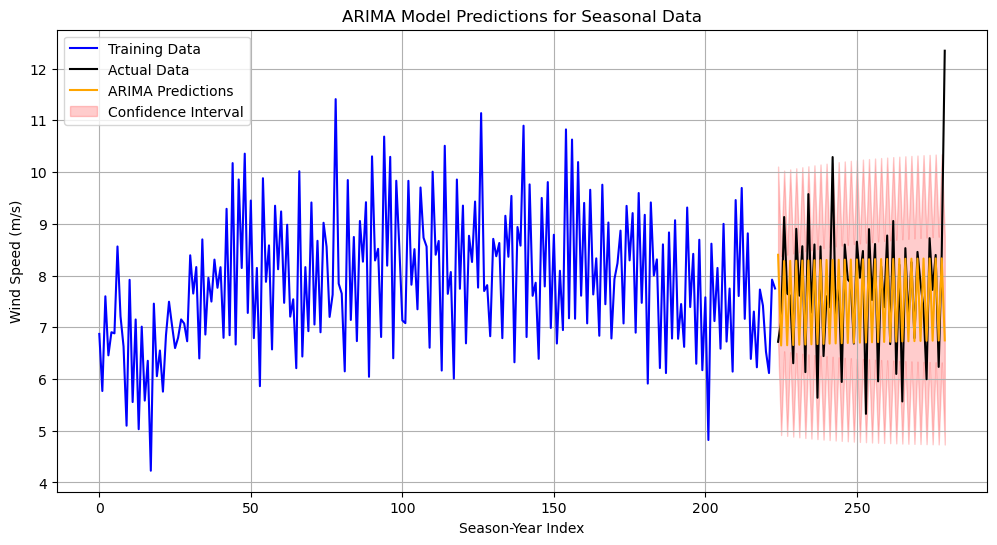

In [29]:
#Initialize and fit the ARIMA model using the training data (`y_train`)
# The order (2, 0, 3) specifies ARIMA(p=2, d=0, q=3), where:
#   p = number of autoregressive terms,
#   d = degree of differencing,
#   q = number of moving average terms
ARIMAmodel = ARIMA(y_train, order=(2, 0, 3))
ARIMAmodel = ARIMAmodel.fit()

# Generate forecasts for the length of the testing dataset (`y_test`)
y_pred = ARIMAmodel.get_forecast(steps=len(y_test))

# Retrieve the confidence intervals for the predictions at 95% confidence level
y_pred_df = y_pred.conf_int(alpha=0.05)

# Add the predicted mean values to the confidence interval DataFrame for easier access
y_pred_df["Predictions"] = y_pred.predicted_mean

# Align the predicted indices with the testing data indices for comparison
y_pred_df.index = y_test.index

# Extract the predicted values from the DataFrame for error calculations
y_pred_out = y_pred_df["Predictions"]

# Calculate evaluation metrics to assess the model's performance
mse = mean_squared_error(y_test, y_pred_out) 
mae = mean_absolute_error(y_test, y_pred_out)  
y_test_corrected = y_test.replace(0, 0.01)
mape = mean_absolute_percentage_error(y_test_corrected, y_pred_out) 

# Print the performance metrics
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")

# Visualization of the ARIMA model's predictions
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, color='blue', label='Training Data')
plt.plot(y_test.index, y_test, color='black', label='Actual Data')
plt.plot(y_pred_out.index, y_pred_out, color='orange', label='ARIMA Predictions')
plt.fill_between(y_pred_df.index, y_pred_df.iloc[:, 0], y_pred_df.iloc[:, 1], color='red', alpha=0.2, label='Confidence Interval')

plt.xlabel('Season-Year Index') 
plt.ylabel('Wind Speed (m/s)') 
plt.title('ARIMA Model Predictions for Seasonal Data')
plt.legend() 
plt.grid(True) 

c:\Users\micha\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error (MSE): 0.8322
Mean Absolute Error (MAE): 0.5689
Mean Absolute Percentage Error (MAPE): 7.09%


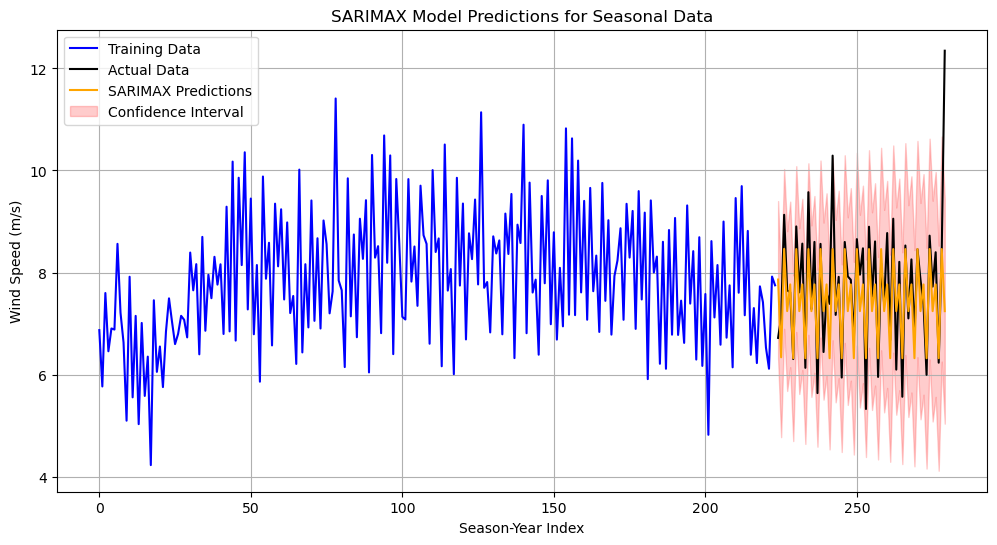

In [30]:
# Initialize and fit the SARIMAX model using the training data (`y_train`)
# The order (1, 0, 0) specifies SARIMAX(p=1, d=0, q=0), where:
#   p = number of autoregressive terms,
#   d = degree of differencing,
#   q = number of moving average terms
# The seasonal_order (1, 1, 1, 4) specifies the seasonal components, where:
#   P = seasonal autoregressive terms,
#   D = seasonal differencing,
#   Q = seasonal moving average terms,
#   s = seasonal period (in this case, 4, assuming quarterly data)
SARIMAXmodel = SARIMAX(
    y_train,  # Training dataset
    order=(1, 0, 0),  # Non-seasonal ARIMA order
    seasonal_order=(1, 1, 1, 4),  # Seasonal ARIMA order
    enforce_stationarity=False,  # Allow non-stationary solutions
    enforce_invertibility=False  # Allow non-invertible solutions
).fit()  # Fit the model

# Generate forecasts for the length of the testing dataset (`y_test`)
y_pred = SARIMAXmodel.get_forecast(steps=len(y_test))

# Retrieve the confidence intervals for the predictions at a 95% confidence level
y_pred_df = y_pred.conf_int(alpha=0.05) 

# Add the predicted mean values to the confidence interval DataFrame for easier access
y_pred_df["Predictions"] = y_pred.predicted_mean

# Align the predicted indices with the testing data indices for proper comparison
y_pred_df.index = y_test.index

# Extract the predicted values from the DataFrame for error calculations
y_pred_out = y_pred_df["Predictions"]

# Calculate evaluation metrics to assess the model's performance
mse = mean_squared_error(y_test, y_pred_out)  
mae = mean_absolute_error(y_test, y_pred_out) 
mape = mean_absolute_percentage_error(y_test.replace(0, 0.01), y_pred_out)

# Print the performance metrics for the SARIMAX model
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")

# Visualization of the SARIMAX model's predictions
plt.figure(figsize=(12, 6))
plt.plot(y_train, label='Training Data', color='blue')
plt.plot(y_test, label='Actual Data', color='black') 
plt.plot(y_pred_out, label='SARIMAX Predictions', color='orange')
plt.fill_between(y_pred_df.index, y_pred_df.iloc[:, 0], y_pred_df.iloc[:, 1], color='red', alpha=0.2, label='Confidence Interval')

plt.xlabel('Season-Year Index')
plt.ylabel('Wind Speed (m/s)') 
plt.title('SARIMAX Model Predictions for Seasonal Data')
plt.legend() 
plt.grid(True)

Mean Squared Error (MSE, HWES): 0.8861
Mean Absolute Error (MAE, HWES): 0.5817
Mean Absolute Percentage Error (MAPE, HWES): 7.18%


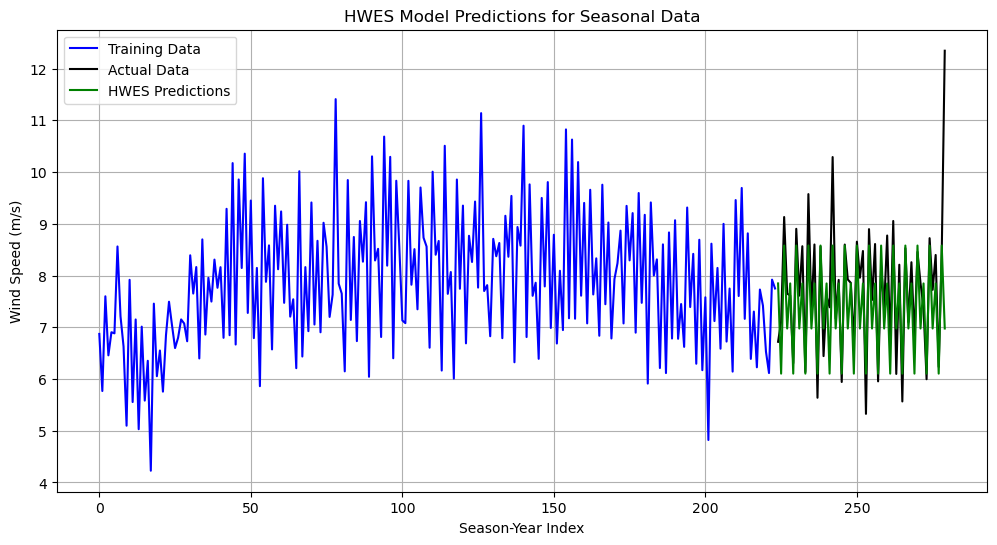

In [31]:
# Initialize and fit the Holt-Winters Exponential Smoothing (HWES) model using training data
# Parameters:
#   seasonal='mul' indicates a multiplicative seasonality model
#   seasonal_periods=4 specifies the seasonal period (e.g., quarterly data)
HWESmodel = ExponentialSmoothing(
    y_train,  
    seasonal='mul',  
    seasonal_periods=4 
)
HWESmodel_fit = HWESmodel.fit() 

# Generate forecasts for the length of the testing dataset (`y_test`)
y_pred_hw = HWESmodel_fit.forecast(len(y_test))  

# Calculate evaluation metrics to assess the model's performance
mse_hw = mean_squared_error(y_test, y_pred_hw)  
mae_hw = mean_absolute_error(y_test, y_pred_hw) 
y_test_corrected = y_test.replace(0, 0.01) 
mape_hw = mean_absolute_percentage_error(y_test_corrected, y_pred_hw)

# Print the performance metrics for the HWES model
print(f"Mean Squared Error (MSE, HWES): {mse_hw:.4f}")
print(f"Mean Absolute Error (MAE, HWES): {mae_hw:.4f}")
print(f"Mean Absolute Percentage Error (MAPE, HWES): {mape_hw * 100:.2f}%")

# Visualization of the HWES model's predictions
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, color='blue', label='Training Data') 
plt.plot(y_test.index, y_test, color='black', label='Actual Data') 
plt.plot(y_test.index, y_pred_hw, color='green', label='HWES Predictions')  

plt.xlabel('Season-Year Index') 
plt.ylabel('Wind Speed (m/s)') 
plt.title('HWES Model Predictions for Seasonal Data') 
plt.legend() 
plt.grid(True)